# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
EPSILON = 1e-8 # small constant to avoid underflow or divide per 0
%matplotlib inline

# I - Linear multidimensional regression

## I a) - Loading the data

In [2]:
data = pd.read_csv('data/linear_multi.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
Y = Y.reshape((Y.shape[0], 1))

## I b) - Problem definition

We can define our MSE cost function $J(\mathbf{\theta})$ as follows:
$$
J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta}) = \frac{1}{2n} \sum_{i=1}^n (Y_i - \mathbf{X_i} \mathbf{\theta})^2
= \frac{1}{2 n} \| \mathbf{Y} - \mathbf{X} \mathbf{\theta} \|_2^2,
$$
with $\mathbf{Y} = [y_1 \cdots y_n]$, $\mathbf{X} = [\mathbf{x_1} \cdots \mathbf{x_n}]$,

$\mathbf{Y} \in \mathbb{R}^{n\times{1}}$ being the vector of labels, $\mathbf{X} \in \mathbb{R}^{n\times{p}}$ being the vector of features, $\mathbf{\theta} \in \mathbb{R}^{p\times{1}}$ being our parameters, and $n$ the number of samples.

Now we can calculate the gradient $\nabla_{\mathbf{\theta}} J$:
$$
\nabla_{\mathbf{\theta}} J(\mathbf{X}, \mathbf{Y})^T = - \frac{1}{n} \sum_{i=1}^n \mathbf{X_i}(Y_i - \mathbf{X_i}\mathbf{\theta})
$$
$$
\nabla_{\mathbf{\theta}} J(\mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \mathbf{X}^T(\mathbf{Y} - \mathbf{X}\mathbf{\theta})
$$

It leads us to the gradient descend (GD) iterative algorithm:
$$
\mathbf{\theta}_{t+1} := \mathbf{\theta}_{t} - \eta_t \nabla_{\mathbf{\theta}} J(\mathbf{X}, \mathbf{Y})
$$

It is common to decay the learning rate linearly until iteration $\tau$:
$$
\eta_t = (1-\alpha)\eta_0 + \alpha \eta_\tau
$$
with $\alpha = \frac{t}{\tau}$, and usually here we are going to take $\tau \approx 200$ and $\eta_\tau = \frac{\eta_0}{100}$

And finally, our linear prediction $\mathbf{\hat{Y}}$ can be expressed as:
$$
\mathbf{\hat{Y}} = \mathbf{X}\mathbf{\theta}
$$

It is also common to add regularization to the loss.

MSE loss with L1 penalty term:
$$
J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta})_{pen} = J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta}) + \gamma \sum_{i=1}^n \mid\mathbf{\theta}_i\mid
$$
MSE loss with L2 penalty term:
$$
J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta})_{pen} = J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta}) + \gamma \sum_{i=1}^n \mathbf{\theta}_i^2
$$

- **You are asked, wherever there are TODO expressions, to change the default expression by the right one**
- **Most expressions you are asked to implement can be found in the introduction above**

In [3]:
class LinearRegressor():
    def __init__(self, X, Y, penalization=None):
        p = X.shape[1]
        self.theta = np.random.normal(0, 1, p).reshape((p, 1))
        self.grad_theta = None
        self.training_losses_history = []
        self.validation_losses_history = []
        self.X_tr, self.X_val, self.Y_tr, self.Y_val = self.split_train_validation(X, Y)
        self.penalization = penalization
        self.gamma = None
        
    def split_train_validation(self, X, Y, test_size=0.25, seed=False):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val
        
    def predict(self, X):
        return X.dot(self.theta)
    
    def compute_grad(self, X, Y, loss='MSE'):
        """Least-squares gradient"""
        assert(X.shape[0] == Y.shape[0])
        n = X.shape[0]
        if loss == 'MSE':
            grad = - (1 / n) * X.T.dot(Y - self.predict(X))
            if self.penalization == 'l2':
                grad += 2 * self.gamma * self.theta
            if self.penalization == 'l1':
                grad += self.gamma * np.sign(self.theta)
        else:
            raise NotImplementedError
        return grad
    
    def step_gradient_descent(self, step, X, Y):
        self.grad_theta = self.compute_grad(X, Y, loss='MSE')
        self.theta -= step * self.grad_theta
        
    def loss(self, Y_true, Y_pred, loss='MSE'):
        """Least-squares loss"""
        assert(Y_true.shape[0] == Y_pred.shape[0])
        n = Y_pred.shape[0]
        if loss == 'MSE':
            loss = (1 / (2 * n)) * np.linalg.norm(Y_true - Y_pred, ord=2) ** 2
            if self.penalization == 'l2':
                loss += self.gamma * np.linalg.norm(self.theta, ord=2) ** 2
            elif self.penalization == 'l1':
                loss += self.gamma * np.linalg.norm(self.theta, ord=1)
        else:
            raise NotImplementedError
        return loss
    
    def loss_history_flush(self):
        self.training_losses_history = []
        self.validation_losses_history = []
    
    ## Goodfellow, p295
    def apply_step_decay(self, initial_step, k, tau=250):
        alpha = min(k / tau, 1)
        step_tau = initial_step / 100
        return (1 - alpha) * initial_step + alpha * step_tau
        
    def fit(self, initial_step=1e-1, min_iterations=50, max_iterations=5000, gamma=1e-3, 
            early_stopping=True, early_stopping_delta=1e-3, early_stopping_lookbehind=50, 
            step_decay=True, flush_history=True, verbose=True):
        if flush_history:
            self.loss_history_flush()
        cpt_patience, best_validation_loss = 0, np.inf
        iteration_number = 0
        step = initial_step
        self.gamma = gamma
        while len(self.training_losses_history) < max_iterations:
            iteration_number += 1
            self.step_gradient_descent(step, self.X_tr, self.Y_tr)
            if step_decay:
                step = self.apply_step_decay(initial_step, iteration_number)
            training_loss = self.loss(self.Y_tr, self.predict(self.X_tr))
            self.training_losses_history.append(training_loss)
            validation_loss = self.loss(self.Y_val, self.predict(self.X_val))
            self.validation_losses_history.append(validation_loss)
            if iteration_number > min_iterations and early_stopping:
                if validation_loss + early_stopping_delta < best_validation_loss:
                    best_validation_loss = validation_loss
                    cpt_patience = 0
                else:
                    cpt_patience += 1
            if verbose:
                msg = "iteration number: {0}\t training loss: {1:.4f}\t validation loss: {2:.4f}"
                print(msg.format(iteration_number, training_loss, validation_loss))
            if cpt_patience >= early_stopping_lookbehind:
                break

    def plot_loss_history(self):
        plt.figure(figsize=(12, 8))
        plt.plot(range(len(self.training_losses_history)), 
                 self.training_losses_history, label='Training loss evolution')
        plt.plot(range(len(self.validation_losses_history)), 
                 self.validation_losses_history, label='Validation loss evolution')
        plt.legend(fontsize=15)
        plt.yscale('log')
        plt.xlabel("iteration number", fontsize=15)
        plt.ylabel("MSE loss", fontsize=15)
        if not self.penalization:
            title = "MSE loss evolution during training, no penalization"
        else:
            title = "MSE loss evolution during training, penalization {}"
            title = title.format(self.penalization)
        plt.title(title, fontsize=20)
        plt.show()
    
    def plot_parameters(self, title=None):
        plt.figure(figsize=(6, 4))
        plt.scatter(range(len(self.theta)), self.theta)
        plt.xlabel("parameter dimension", fontsize=15)
        plt.ylabel("value", fontsize=15)
        if title is None:
            if not self.penalization:
                plt.title("Scatter plot of the learned parameters, no penalization", fontsize=15)
            else:
                plt.title(
                    "Scatter plot of the learned parameters, penalization {}".format(self.penalization), fontsize=15
                )
        else:
                plt.title(title)
        plt.show()

In [4]:
linear_regressor = LinearRegressor(X, Y)
ridge_linear_regressor = LinearRegressor(X, Y, penalization='l2')
lasso_linear_regressor = LinearRegressor(X, Y, penalization='l1')

linear_regressor.fit(verbose=True)
ridge_linear_regressor.fit(gamma=1e-3, verbose=True, step_decay=True)
lasso_linear_regressor.fit(gamma=1e-3, verbose=True, step_decay=True)

iteration number: 1	 training loss: 8748.1399	 validation loss: 8520.7583
iteration number: 2	 training loss: 7009.7085	 validation loss: 6863.7842
iteration number: 3	 training loss: 5632.1898	 validation loss: 5543.9967
iteration number: 4	 training loss: 4538.4959	 validation loss: 4490.6920
iteration number: 5	 training loss: 3668.4346	 validation loss: 3648.4094
iteration number: 6	 training loss: 2974.9189	 validation loss: 2973.5604
iteration number: 7	 training loss: 2421.0444	 validation loss: 2431.8204
iteration number: 8	 training loss: 1977.8334	 validation loss: 1996.1069
iteration number: 9	 training loss: 1622.4898	 validation loss: 1645.0104
iteration number: 10	 training loss: 1337.0464	 validation loss: 1361.5735
iteration number: 11	 training loss: 1107.3161	 validation loss: 1132.3393
iteration number: 12	 training loss: 922.0751	 validation loss: 946.6083
iteration number: 13	 training loss: 772.4278	 validation loss: 795.8578
iteration number: 14	 training loss: 6

iteration number: 113	 training loss: 111.5291	 validation loss: 105.9538
iteration number: 114	 training loss: 111.5291	 validation loss: 105.9532
iteration number: 115	 training loss: 111.5291	 validation loss: 105.9527
iteration number: 116	 training loss: 111.5290	 validation loss: 105.9522
iteration number: 117	 training loss: 111.5290	 validation loss: 105.9517
iteration number: 118	 training loss: 111.5290	 validation loss: 105.9512
iteration number: 119	 training loss: 111.5289	 validation loss: 105.9508
iteration number: 120	 training loss: 111.5289	 validation loss: 105.9504
iteration number: 121	 training loss: 111.5289	 validation loss: 105.9500
iteration number: 122	 training loss: 111.5289	 validation loss: 105.9497
iteration number: 123	 training loss: 111.5288	 validation loss: 105.9493
iteration number: 124	 training loss: 111.5288	 validation loss: 105.9490
iteration number: 125	 training loss: 111.5288	 validation loss: 105.9487
iteration number: 126	 training loss: 

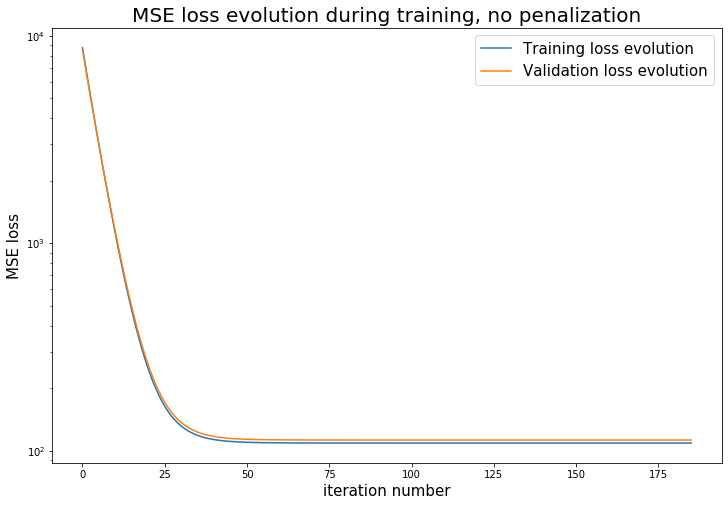

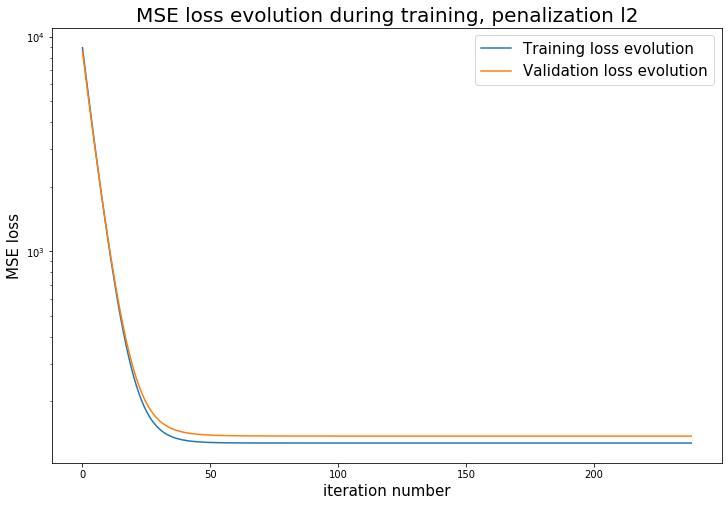

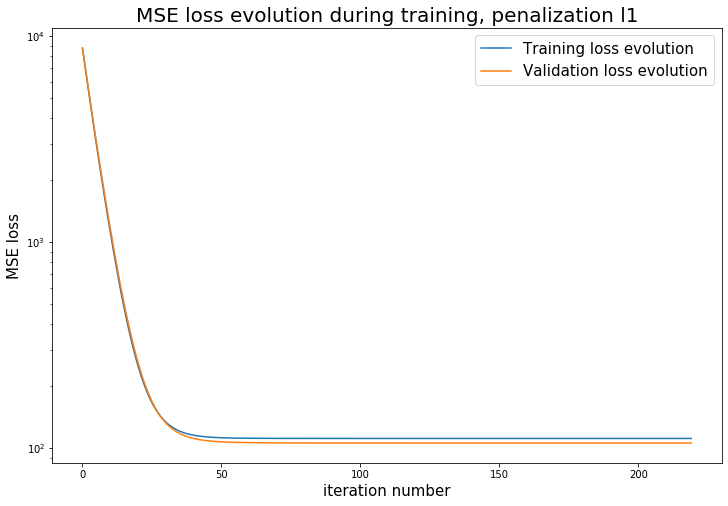

In [5]:
linear_regressor.plot_loss_history()
ridge_linear_regressor.plot_loss_history()
lasso_linear_regressor.plot_loss_history()

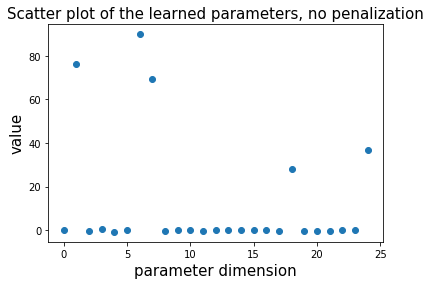

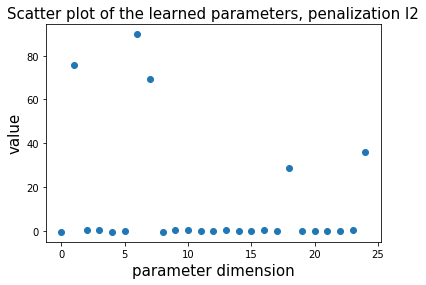

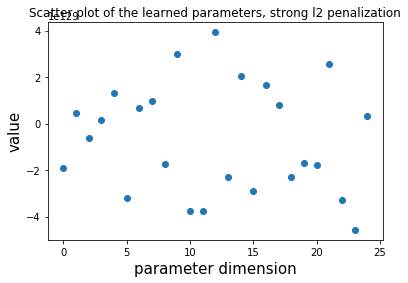

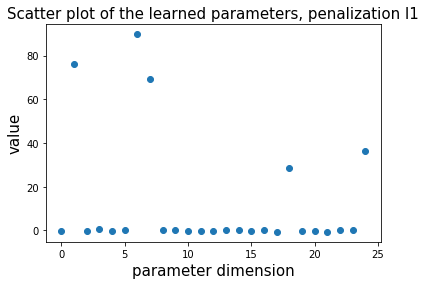

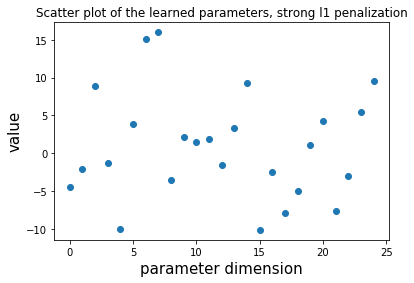

In [6]:
#linear
linear_regressor.plot_parameters()

# ridge
    # normal ridge
ridge_linear_regressor.plot_parameters()
    # strong l2 regularization
ridge_linear_regressor = LinearRegressor(X, Y, penalization='l2')
ridge_linear_regressor.fit(gamma=1e2, verbose=False, step_decay=False)
title = "Scatter plot of the learned parameters, strong l2 penalization"
ridge_linear_regressor.plot_parameters(title)

# lasso
    # normal lasso
lasso_linear_regressor.plot_parameters()
    # strong l1 regularization
lasso_linear_regressor = LinearRegressor(X, Y, penalization='l1')
lasso_linear_regressor.fit(gamma=1e2, verbose=False, step_decay=False)
title = "Scatter plot of the learned parameters, strong l1 penalization"
lasso_linear_regressor.plot_parameters(title)

## Questions:
#### - What are l1 and l2 penalization strategies useful for? Did you achieve to improve your model's performance with them? Try different penalization values.
<span style="color:green">
Both strategies prevent weights from reaching extreme values to control complexity of the model and prevent overfitting.<br/>
L1 penalization may lead to sparse weights, thus can it be used as a model memory reduction strategy.<br/>
L2 shrinks all weights closer to zero, not exatly zero, and is more suited to algorithms that require perfect differentiability and smoothness
</span>

#### - Consider the parameters plot. What could you conclude about the features information?
<span style="color:green">
In case right-fitting with normal l1 and l2 penalizations most weights end-up very close to zeros. That is because the features associated to those weights are not statistically relevant for the prediction. We can conclude there are $5$ features that are informative to the prediction.
</span>  

# II - Non linear unidimensional regression

## II a) - Loading the data

In [7]:
data = pd.read_csv('data/non_linear.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
X, Y = X.reshape((Y.shape[0], 1)), Y.reshape((Y.shape[0], 1))

## II b) - Visualizing the data

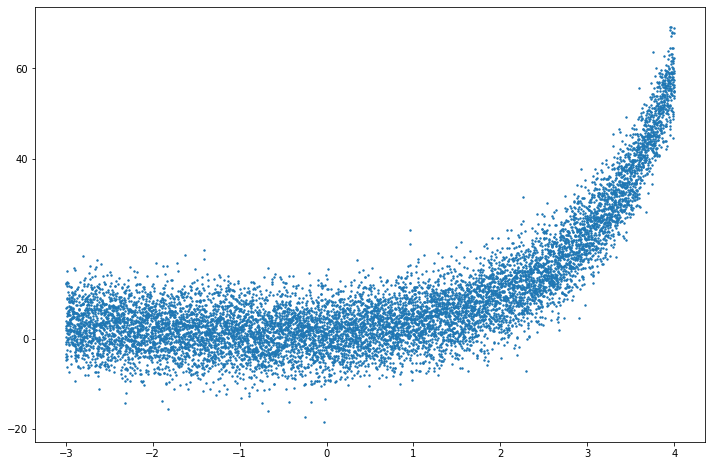

In [8]:
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, s=2)
plt.show()

- Notice the relation between $X$ and $Y$ is non linear
- You are supposed to map X to a new non linear representation more suited to the type of dependance between $X$ and $y$
- Using this new representation of $X$ use the linear regressor properties from the beginning to perform predictions

In [9]:
class PolynomialRegressor(LinearRegressor):
    def __init__(self, X, Y, degree=2, penalization=None):
        self.degree = degree
        self.initial_X_tr, self.initial_X_val, _, _ = self.split_train_validation(X, Y)
        X_transformed = self.non_linear_mapping(X)
        super(PolynomialRegressor, self).__init__(X_transformed, Y, penalization)
        
    def split_train_validation(self, X, Y, test_size=0.25, seed=True):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val
        
    def non_linear_mapping(self, X):
        return np.hstack([X**i for i in range(self.degree+1)])
    
    def predict(self, X, apply_features_transformation=False):
        if apply_features_transformation:
            X_transformed = self.non_linear_mapping(X)
            return super(PolynomialRegressor, self).predict(X_transformed)
        else:
            return super(PolynomialRegressor, self).predict(X)
        
    def plot_prediction(self):
        assert self.initial_X_val.shape[1] == 1, "Too high dimensional design matrix to be plotted!"
        plt.figure(figsize=(12, 8))
        plt.scatter(self.initial_X_val, self.Y_val, s=5)
        plt.scatter(
            self.initial_X_val, self.predict(self.initial_X_val, apply_features_transformation=True), 
            color='red', s=5
        )
        plt.title("Prediction with polynomial regressor, degree={}".format(self.degree), fontsize=15)
        plt.show()

In [10]:
polynomial_regressor = PolynomialRegressor(X, Y, degree=2)
polynomial_regressor.fit(initial_step=1e-2, max_iterations=500, verbose=True)

iteration number: 1	 training loss: 145.1509	 validation loss: 152.5523
iteration number: 2	 training loss: 77.6144	 validation loss: 81.4860
iteration number: 3	 training loss: 50.8190	 validation loss: 52.7202
iteration number: 4	 training loss: 39.8157	 validation loss: 40.5814
iteration number: 5	 training loss: 34.9845	 validation loss: 35.0818
iteration number: 6	 training loss: 32.5967	 validation loss: 32.2963
iteration number: 7	 training loss: 31.1990	 validation loss: 30.6617
iteration number: 8	 training loss: 30.2208	 validation loss: 29.5440
iteration number: 9	 training loss: 29.4361	 validation loss: 28.6792
iteration number: 10	 training loss: 28.7538	 validation loss: 27.9535
iteration number: 11	 training loss: 28.1360	 validation loss: 27.3150
iteration number: 12	 training loss: 27.5661	 validation loss: 26.7384
iteration number: 13	 training loss: 27.0359	 validation loss: 26.2102
iteration number: 14	 training loss: 26.5408	 validation loss: 25.7222
iteration num

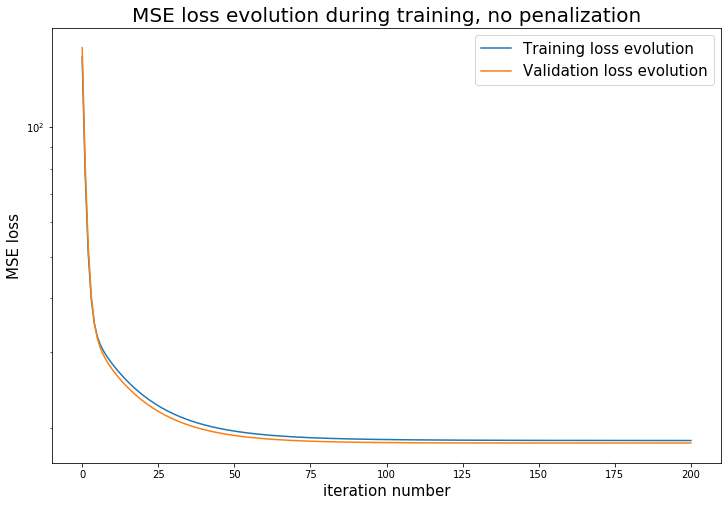

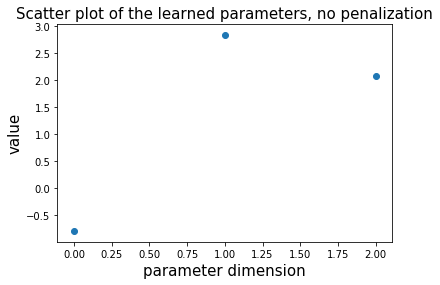

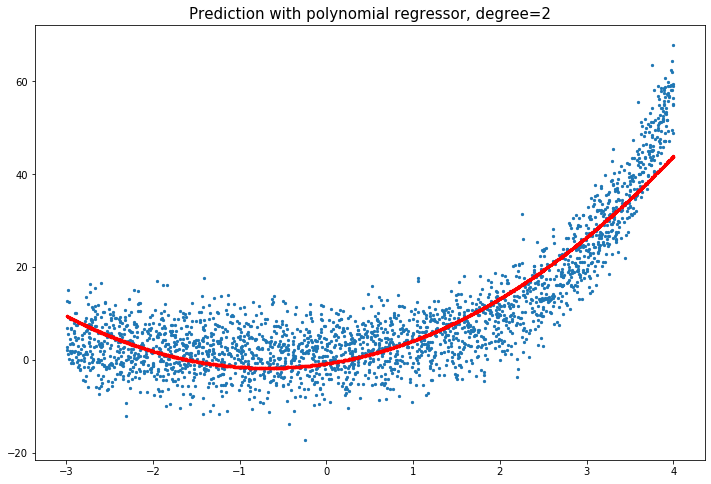

In [11]:
polynomial_regressor.plot_loss_history()
polynomial_regressor.plot_parameters()
polynomial_regressor.plot_prediction()

iteration number: 1	 training loss: 3091.1367	 validation loss: 3170.6205
iteration number: 2	 training loss: 2819.1477	 validation loss: 2891.0109
iteration number: 3	 training loss: 2573.1206	 validation loss: 2638.1000
iteration number: 4	 training loss: 2350.4909	 validation loss: 2409.2502
iteration number: 5	 training loss: 2148.9551	 validation loss: 2202.0922
iteration number: 6	 training loss: 1966.4435	 validation loss: 2014.4974
iteration number: 7	 training loss: 1801.0958	 validation loss: 1844.5524
iteration number: 8	 training loss: 1651.2391	 validation loss: 1690.5368
iteration number: 9	 training loss: 1515.3687	 validation loss: 1550.9029
iteration number: 10	 training loss: 1392.1308	 validation loss: 1424.2584
iteration number: 11	 training loss: 1280.3067	 validation loss: 1309.3499
iteration number: 12	 training loss: 1178.7991	 validation loss: 1205.0489
iteration number: 13	 training loss: 1086.6194	 validation loss: 1110.3387
iteration number: 14	 training los

iteration number: 482	 training loss: 104.3205	 validation loss: 103.8463
iteration number: 483	 training loss: 104.3182	 validation loss: 103.8440
iteration number: 484	 training loss: 104.3159	 validation loss: 103.8417
iteration number: 485	 training loss: 104.3136	 validation loss: 103.8395
iteration number: 486	 training loss: 104.3113	 validation loss: 103.8372
iteration number: 487	 training loss: 104.3089	 validation loss: 103.8350
iteration number: 488	 training loss: 104.3066	 validation loss: 103.8327
iteration number: 489	 training loss: 104.3043	 validation loss: 103.8305
iteration number: 490	 training loss: 104.3020	 validation loss: 103.8282
iteration number: 491	 training loss: 104.2997	 validation loss: 103.8260
iteration number: 492	 training loss: 104.2974	 validation loss: 103.8237
iteration number: 493	 training loss: 104.2951	 validation loss: 103.8215
iteration number: 494	 training loss: 104.2927	 validation loss: 103.8192
iteration number: 495	 training loss: 

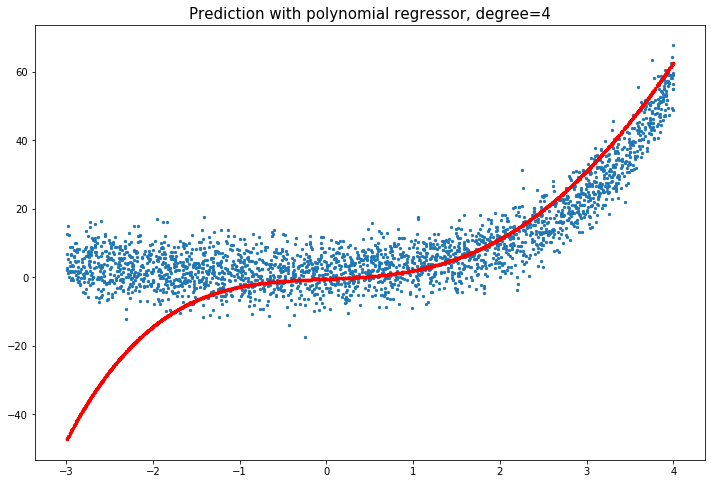

In [12]:
polynomial_regressor = PolynomialRegressor(X, Y, degree=4)
polynomial_regressor.fit(initial_step=1e-5, max_iterations=500, verbose=True)
polynomial_regressor.plot_prediction()

## Questions:
#### - Did you succeed to fit the data using a non linear mapping transformation?
#### - Try different degrees, which one leads you to the best validation error?
<span style="color:green">
No right answer here, we only want to compare your strategies to tackle the problem, but you can get satisfying results using degree=4.
</span>  

# III - Logistic regression

## III a) - Loading the data

In [13]:
data = pd.read_csv('data/breast_cancer_classification.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
Y = Y.reshape((Y.shape[0], 1))

## III b) - Problem definition

Using the sigmoid function $\sigma(x)$ defined as:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

We can define our binary cross-entropy cost function $J(\theta)$ as follows:
$$
J(\mathbf{X}, \mathbf{Y}; \theta) = -\frac{1}{n} \sum_{i=1}^n Y_i \log \sigma(\mathbf{X_i}\mathbf{\theta}) + (1 - Y_i) \log (1 - \sigma(\mathbf{X_i} \mathbf{\theta})),
$$
with $\mathbf{Y} = [y_1 \cdots y_n]$, $\mathbf{X} = [\mathbf{x_1} \cdots \mathbf{x_n}]$,

$\mathbf{Y} \in \mathbb{R}^{n\times{1}}$ being the vector of labels, $\mathbf{X} \in \mathbb{R}^{n\times{p}}$ being the vector of features, $\mathbf{\theta} \in \mathbb{R}^{p\times{1}}$ being our parameters, and $n$ the number of samples.

Now we can calculate the gradient $\nabla J(\mathbf{\theta})$:
$$
\nabla_{\theta} J(\mathbf{X}, \mathbf{Y})^T = - \frac{1}{n} \sum_{i=1}^n \mathbf{X_i}(Y_i - \sigma(\mathbf{X_i}\mathbf{\theta}))
$$
$$
\nabla_{\theta} J(\mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \mathbf{X}^T(\mathbf{Y} - \sigma(\mathbf{X}\theta))
$$

It leads us to the gradient descend (GD) iterative algorithm:
$$
\mathbf{\theta}_{t+1} := \mathbf{\theta}_{t} - \eta_t \nabla_{\theta} J(\mathbf{X}, \mathbf{Y})
$$

And finally, our linear prediction $\mathbf{\hat{Y}}$ can be expressed as:
$$
\mathbf{\hat{Y}} = \sigma(\mathbf{X}\mathbf{\theta})
$$
- **no $\mathbf{\hat{Y}}_i$ should reach $0$ or $1$. If it does get rounded to $0$ or $1$, prevent that from happening by adding or removing EPSILON to $\mathbf{\hat{Y}}_i$**

In [14]:
class LogisticRegressor(LinearRegressor):
    def __init__(self, X, Y, penalization=None):
        super(LogisticRegressor, self).__init__(X, Y, penalization)
        self.X_tr, self.X_val = self.normalize(self.X_tr), self.normalize(self.X_val)
        
    def normalize(self, X):
        X -= np.mean(X, axis=0)
        try:
            X /= np.std(X, axis=0)
        except ZeroDivisionError as e:
            warnings.warn("At least one column passed has 0 std thus cannot be scaled to 1 std")
            X /= np.std(X, axis=0) + EPSILON
        return X
    
    def accuracy_on_validation(self):
        y_pred = self.predict(self.X_val)
        y_pred = np.hstack([1-y_pred, y_pred]) # to format to a [0, 1] probabilities matrix
        return (np.argmax(y_pred, axis=1) == np.squeeze(self.Y_val)).mean()
        
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

    def predict(self, X, apply_normalization=False):
        if apply_normalization:
            X = self.normalize(X)
        return self.sigmoid(X.dot(self.theta))

    def compute_grad(self, X, Y, loss='CE'):
        """Binary cross-entropy gradient"""
        assert(X.shape[0] == Y.shape[0])
        n = X.shape[0]
        if loss == 'CE':
            grad = -(1 / n) * X.T.dot(Y - self.predict(X))
            if self.penalization == 'l2':
                grad += 2 * self.gamma * self.theta
            if self.penalization == 'l1':
                grad += self.gamma * np.sign(self.gamma)
        else:
            raise NotImplementedError
        return grad

    def step_gradient_descent(self, step, X, Y):
        self.grad_theta = self.compute_grad(X, Y, loss='CE')
        self.theta -= step * self.grad_theta

    def loss(self, Y_true, Y_pred, loss='CE'):
        """Binary cross-entropy loss"""
        assert(Y_true.shape[0] == Y_pred.shape[0])
        n = Y_true.shape[0]
        if loss == 'CE':
            loss = -np.mean(Y_true*np.log(Y_pred+EPSILON) + (1-Y_true)*np.log(1-Y_pred+EPSILON))
            if self.penalization == 'l2':
                loss += self.gamma * np.linalg.norm(self.theta, ord=2) ** 2
            elif self.penalization == 'l1':
                loss += self.gamma * np.linalg.norm(self.theta, ord=1)
        else:
            raise NotImplementedError
        return loss

iteration number: 1	 training loss: 1.1524	 validation loss: 1.4293
iteration number: 2	 training loss: 0.9842	 validation loss: 1.2407
iteration number: 3	 training loss: 0.8559	 validation loss: 1.0975
iteration number: 4	 training loss: 0.7577	 validation loss: 0.9885
iteration number: 5	 training loss: 0.6809	 validation loss: 0.9031
iteration number: 6	 training loss: 0.6191	 validation loss: 0.8339
iteration number: 7	 training loss: 0.5683	 validation loss: 0.7767
iteration number: 8	 training loss: 0.5256	 validation loss: 0.7286
iteration number: 9	 training loss: 0.4894	 validation loss: 0.6878
iteration number: 10	 training loss: 0.4583	 validation loss: 0.6528
iteration number: 11	 training loss: 0.4313	 validation loss: 0.6225
iteration number: 12	 training loss: 0.4080	 validation loss: 0.5959
iteration number: 13	 training loss: 0.3876	 validation loss: 0.5725
iteration number: 14	 training loss: 0.3699	 validation loss: 0.5518
iteration number: 15	 training loss: 0.3545

iteration number: 686	 training loss: 0.0759	 validation loss: 0.1746
iteration number: 687	 training loss: 0.0759	 validation loss: 0.1745
iteration number: 688	 training loss: 0.0759	 validation loss: 0.1745
iteration number: 689	 training loss: 0.0759	 validation loss: 0.1744
iteration number: 690	 training loss: 0.0758	 validation loss: 0.1744
iteration number: 691	 training loss: 0.0758	 validation loss: 0.1743
iteration number: 692	 training loss: 0.0758	 validation loss: 0.1743
iteration number: 693	 training loss: 0.0758	 validation loss: 0.1742
iteration number: 694	 training loss: 0.0757	 validation loss: 0.1742
iteration number: 695	 training loss: 0.0757	 validation loss: 0.1741
iteration number: 696	 training loss: 0.0757	 validation loss: 0.1741
iteration number: 697	 training loss: 0.0757	 validation loss: 0.1740
iteration number: 698	 training loss: 0.0756	 validation loss: 0.1740
iteration number: 699	 training loss: 0.0756	 validation loss: 0.1739
iteration number: 70

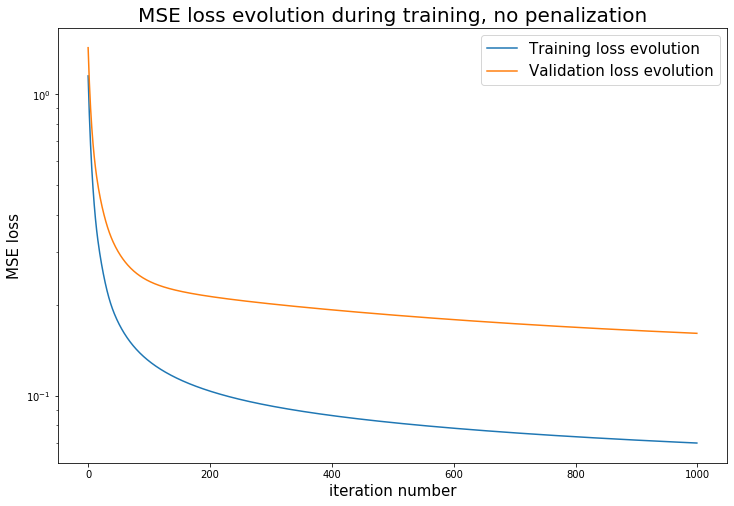

In [15]:
# log reg without regularization
logistic_regressor = LogisticRegressor(X, Y)
logistic_regressor.fit(max_iterations=1000, initial_step=1e-1, step_decay=False)
print(logistic_regressor.accuracy_on_validation())
logistic_regressor.plot_loss_history()

iteration number: 1	 training loss: 3.2541	 validation loss: 3.5474
iteration number: 2	 training loss: 3.0726	 validation loss: 3.3487
iteration number: 3	 training loss: 2.9036	 validation loss: 3.1627
iteration number: 4	 training loss: 2.7461	 validation loss: 2.9886
iteration number: 5	 training loss: 2.5992	 validation loss: 2.8257
iteration number: 6	 training loss: 2.4620	 validation loss: 2.6732
iteration number: 7	 training loss: 2.3338	 validation loss: 2.5303
iteration number: 8	 training loss: 2.2140	 validation loss: 2.3963
iteration number: 9	 training loss: 2.1019	 validation loss: 2.2707
iteration number: 10	 training loss: 1.9969	 validation loss: 2.1528
iteration number: 11	 training loss: 1.8985	 validation loss: 2.0421
iteration number: 12	 training loss: 1.8063	 validation loss: 1.9382
iteration number: 13	 training loss: 1.7199	 validation loss: 1.8406
iteration number: 14	 training loss: 1.6389	 validation loss: 1.7489
iteration number: 15	 training loss: 1.5629

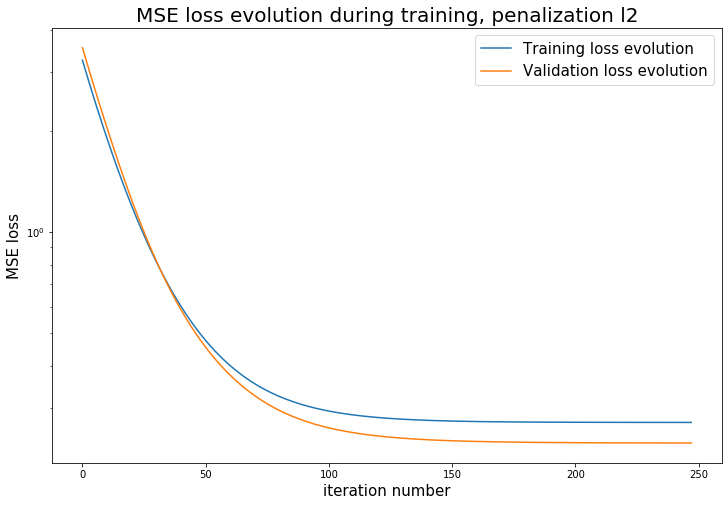

In [22]:
# log reg with l2 regularization
logistic_regressor = LogisticRegressor(X, Y, penalization='l2')
logistic_regressor.fit(max_iterations=1000, gamma=1e-1, initial_step=1e-1, step_decay=False)
print(logistic_regressor.accuracy_on_validation())
logistic_regressor.plot_loss_history()

iteration number: 1	 training loss: 1.8276	 validation loss: 1.9104
iteration number: 2	 training loss: 1.6015	 validation loss: 1.6944
iteration number: 3	 training loss: 1.4220	 validation loss: 1.5219
iteration number: 4	 training loss: 1.2757	 validation loss: 1.3812
iteration number: 5	 training loss: 1.1546	 validation loss: 1.2636
iteration number: 6	 training loss: 1.0538	 validation loss: 1.1641
iteration number: 7	 training loss: 0.9701	 validation loss: 1.0799
iteration number: 8	 training loss: 0.8999	 validation loss: 1.0088
iteration number: 9	 training loss: 0.8395	 validation loss: 0.9480
iteration number: 10	 training loss: 0.7868	 validation loss: 0.8952
iteration number: 11	 training loss: 0.7406	 validation loss: 0.8489
iteration number: 12	 training loss: 0.6999	 validation loss: 0.8079
iteration number: 13	 training loss: 0.6639	 validation loss: 0.7714
iteration number: 14	 training loss: 0.6319	 validation loss: 0.7388
iteration number: 15	 training loss: 0.6034

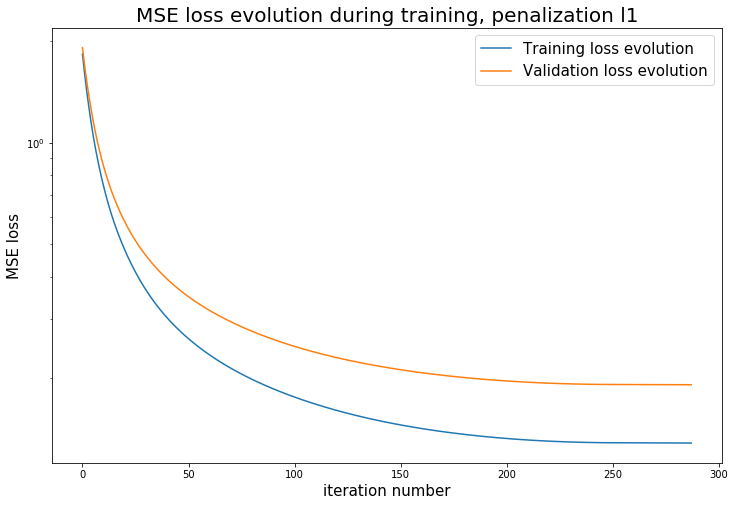

In [23]:
# log reg with l1 regularization
logistic_regressor = LogisticRegressor(X, Y, penalization='l1')
logistic_regressor.fit(max_iterations=1000, gamma=1e-4, initial_step=1e-1, step_decay=True)
print(logistic_regressor.accuracy_on_validation())
logistic_regressor.plot_loss_history()

## Questions:
#### - Describe your normalization strategy and why it is important
<span style="color:green">
One strategy that works well here is to center your columns data and give them a $1$ standard deviation to control the weights' derivatives of features on large scales.<br/>
Adviced transformation: $X' = \frac{X - \mu}{\sigma}$ <br/>
$X'$ your transformed column data, X former column, $\mu$ column mean, $\sigma$ column standard deviation 
</span>

#### - Why do we need a different loss function for a classification problem (why not MSE again?)
<span style="color:green">
With MSE the final function to minimize wouldn't be convex while it actually is convex with negative loglikelihood loss. It is thus far more suited to gradient descent optimization.<br/>
Wrong predictions are also penalized exponentially, which leads to bad predictions being corrected within fewer gradient descent iterations</span>

#### - Why is the normalization particulary relevant in this case? Compare the performances with and without it. Comment. 
<span style="color:green">
As previously mentioned, there are many features initially on different scales. Features on greater scales may lead to big derivatives and uncontrolled training due to the same learning rate being applied in all directions of the gradients.
</span>